In [5]:
import emcee
import corner
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
print('There are: '+str(cpu_count())+' CPUs')
from correlation_fcts import *

There are: 6 CPUs


/Data/meech/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Data/meech/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar'

In [6]:
c0 = Constants().c0

## SPIRou first

In [8]:
# input spirou data
datafile = 'Input_data/spirou/inject_amp2.0_Kp83.0_vsys10.00_CH4/airmass_deg2/PCA/noLS/reduced_1.pkl'
with open(datafile,'rb') as specfile:
    A = pickle.load(specfile)
orders,WW,Ir,T_obs,phase,window,berv,vstar,airmass,SN,SNR_mes,SNR_mes_pca,Imask,mask = A

In [9]:
# forward model
model_dir = 'Models/1x_metallicity_1.0_CO_ratio/'
sp        = 'CH4'
mod_file  = model_dir+'pRT_data_full_{}.dat'.format(sp)
W_mod     = []
T_depth   = []
with open(mod_file, 'r') as data:
    lines = data.readlines()
    data.close()
for line in lines[4:]:
    v = line.split(' ')
    W_mod.append(float(v[0]))
    T_depth.append(float(v[1].split('\n')[0]))
W_mod = np.array(W_mod)/1e3
T_depth = np.array(T_depth)
T_depth = (1 + 2.*(T_depth-1))

In [11]:
# create order objects
use_masked = False
list_ord = []
nord = len(orders)
for nn in range(nord):
    O        = Order(orders[nn])
    O.W_fin  = np.array(WW[nn],dtype=float)
    O.W_fin  /= 1e3 # hack to convert to um (make universal later)
    O.SNR    = np.array(SN[nn],dtype=float)
    O.W_mean = O.W_fin.mean()
    if use_masked:
        O.I_pca = np.array(Imask[nn],dtype=float)
    else:
        O.I_pca  = np.array(Ir[nn],dtype=float)

    ### purge NaNs
    l = np.ones_like(O.W_fin,'bool')
    for ipix in range(len(O.I_pca[0])):
        if np.isnan(O.I_pca[:,ipix]).any():
            l[ipix] = False
    O.W_fin = O.W_fin[l]
    O.I_pca = O.I_pca[:,l]
    Wmin,Wmax = 0.95*O.W_fin.min(),1.05*O.W_fin.max()
    indm      = np.where((W_mod>Wmin)&(W_mod<Wmax))[0]
    O.Wm      = W_mod#indm]
    O.Im      = T_depth#[indm]

    list_ord.append(O)

In [27]:
##########################################
##### Define Prior and Loglikelihood #####
##########################################

# theta:
# - kp
# - vsys
# - a (scaling parameter)

#per order
# run for one order for now to check it works
for nn in range(len(list_ord)):
    O     = list_ord[nn]
    if nn==0:
        flux = O.I_pca
        wlens = O.W_fin
    else:
        flux = np.concatenate((flux,O.I_pca),axis=1)
        wlens = np.concatenate((wlens,O.W_fin),axis=0)

nep,npix = flux.shape
print(nep,npix)
f = flux - np.nanmean(flux, axis=1)[:, np.newaxis]
f2 = np.nansum(f**2, axis=1)

pscale = np.sin(2*np.pi*phase)
Vshift = vstar-berv

# the forward model
planetspec = interp.interp1d(O.Wm,O.Im)

def prior(theta):
    
    # stop velocity wandering off
    if theta[0]>400 or theta[0]<-400: return False
    if theta[1]>400 or theta[1]<-400: return False
    
    return True

def log_prob(theta):

    if prior(theta)==False: return - np.inf
    
    Kp = theta[0]
    Vsys = theta[1]

    # interpolate model
    mod = np.zeros(flux.shape)
    for iep in range(nep):
        mod[iep] = planetspec(wlens*( 1 - (Vsys + Kp*pscale[iep] + Vshift[iep])/c0)) # taylor expansion (rather than division)
    
    g = mod - np.nanmean(mod, axis=1)[:, np.newaxis]
    #g /= np.nanstd(mod, axis=1)[:, np.newaxis]
    
    fg = np.nansum(f*g, axis=1)
    g2 = np.nansum(g**2, axis=1)
    logl = - npix/2 * np.nansum( np.log(1/npix * (f2 - 2*fg + g2)) )

    return logl

78 141889


In [28]:
#####################################
##### Initial params and labels #####
#####################################

med = [83., 0]
std = [10., 10.]

labels = ['Kp', 'Vsys']

In [29]:
###############################
##### Run MCMC (too slow) #####
###############################
ndim, nwalkers = 2, 10 # for now just fit velocity
p0 = np.random.randn(nwalkers, ndim)
for i in range(ndim):
    p0[:,i] = p0[:,i]*std[i] + med[i]
    
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)
    sampler.run_mcmc(p0, 500, progress=True)

100%|██████████| 500/500 [23:10<00:00,  3.24s/it]


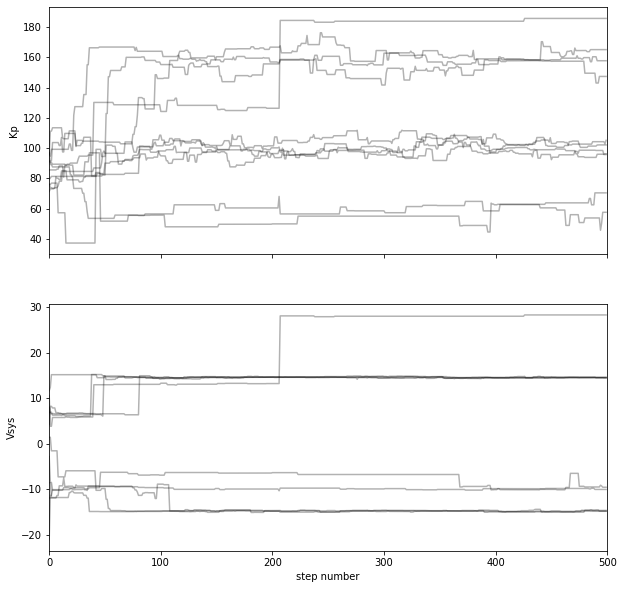

In [30]:
#############################
##### Check MCMC chains #####
#############################

fig, axes = plt.subplots(ndim, figsize=(10, 10), sharex=True)
samples = sampler.get_chain()
cut=0 #remove initial n steps from plot

for i in range(ndim):
    ax = axes[i]
    ax.plot(np.arange(len(samples))[cut:], samples[cut:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number")
#plt.savefig('./chains.png')
plt.show()
plt.close()


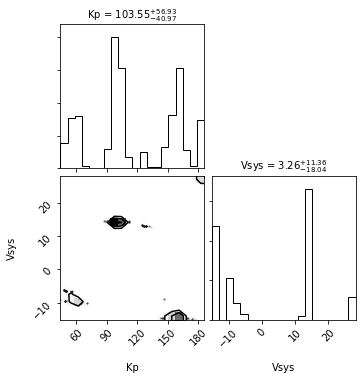

In [31]:
###############################
##### Plot output of MCMC #####
###############################

n = 100 #burn in
flat_samples = sampler.get_chain(discard=n, flat=True)
figure = corner.corner(flat_samples, labels=labels, show_titles=True, title_kwargs={"fontsize": 10})
#plt.savefig('./corner.png')
plt.show()
plt.close()

hd = ''
for l in labels: hd += l +','
#np.savetxt('./chains.csv', flat_samples, delimiter=",", header=hd[:-1])

In [32]:
# instead of MCMC step through a grid of velocities:
l_kp = np.arange(0,150,5)
l_kv_sys = np.arange(-30,30,2)
lik = np.zeros((len(l_kv_sys), len(l_kp)))
for j in range(len(l_kp)):
    for k in range(len(l_kv_sys)):
        lik[k,j] = log_prob([l_kp[j], l_kv_sys[k]])

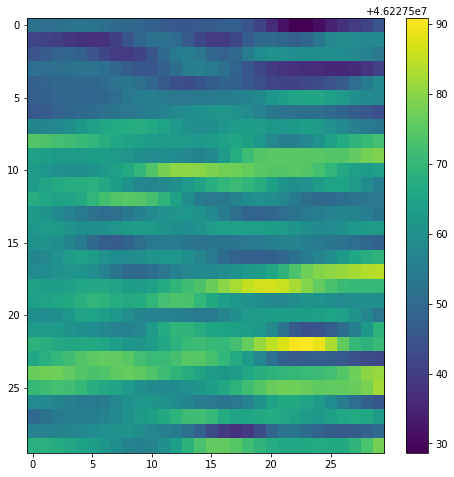

In [35]:
plt.figure(figsize=(8,8))
plt.imshow(lik,aspect='auto')
#plt.xlabel()
plt.colorbar()
plt.savefig('ll.png')